<a href="https://colab.research.google.com/github/Kizza2014/thyroid_cell_prediction_on_he_images/blob/main/notebooks/cell_prediction_feature1234.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import pandas as pd
import os
import json
from scipy.fftpack import fft2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -q /content/drive/MyDrive/data/cell_prediction/image_with_points.zip -d /content/

## 1. Đặc trưng 1: Nhân hình oval,...

##### Helper function để trích xuất đặc trưng:

In [ ]:
# helper functions
from typing import List, Tuple
from shapely.geometry import Polygon, LineString
import math

def geo_area(cells_list: List[Polygon]) -> List[float]:
    areas = []
    for i in range(0, len(cells_list)):
        areas.append(cells_list[i].area)
    return areas

def geo_solidity(cells_list: List[Polygon]) -> List[float]:
    solidit = []
    for i in range(0, len(cells_list)):
        solidit.append((cells_list[i].area) / ((cells_list[i].convex_hull).area))

    return solidit

def geo_eccentricity(cells_list: List[Polygon]) -> List[float]:
    eccentr = []
    for i in range(0, len(cells_list)):
        points = list(zip(*cells_list[i].minimum_rotated_rectangle.exterior.coords.xy))
        lengths = [
            LineString((points[j], points[j + 1])).length
            for j in range(len(points) - 1)
        ]

        # get major/minor axis measurements
        min_axis = min(lengths)
        max_axis = max(lengths)
        a = max_axis / 2
        b = min_axis / 2

        eccentr.append(np.sqrt(np.square(a) - np.square(b)) / a)

    return eccentr

def geo_rotation(cells_list: List[Polygon]) -> List[float]:
    rot_ang = []
    for i in range(0, len(cells_list)):

        rect = np.array(cells_list[i].minimum_rotated_rectangle.exterior.coords)
        edges = []
        for d in np.diff(rect, axis=0):
            length = np.sqrt(d[0] ** 2 + d[1] ** 2)
            angle = np.arctan2(d[1], d[0])
            edges.append([length, angle])

        edges = np.array(edges)
        angle_value = edges[np.argmax(edges[:, 0])][1]
        # Check if the angle is between -pi/2 and pi/2
        if angle_value > np.pi / 2:
            angle_value -= np.pi
        elif angle_value < -np.pi / 2:
            angle_value += np.pi
        rot_ang.append(angle_value)

    return rot_ang

def geo_axis(cells_list: List[Polygon]) -> Tuple[List[float], List[float], List[float]]:
    minor_axis = []
    major_axis = []
    aspect_ratio = []
    for i in range(0, len(cells_list)):
        mbr_points = list(
            zip(*cells_list[i].minimum_rotated_rectangle.exterior.coords.xy)
        )

        # calculate the length of each side of the minimum bounding rectangle
        mbr_lengths = [
            LineString((mbr_points[i], mbr_points[i + 1])).length
            for i in range(len(mbr_points) - 1)
        ]

        # get major/minor axis measurements
        minor_axis.append(min(mbr_lengths))
        major_axis.append(max(mbr_lengths))
        aspect_ratio.append(max(mbr_lengths) / min(mbr_lengths))

    return minor_axis, major_axis, aspect_ratio

def geo_roundness(cells_list: List[Polygon]) -> List[float]:
    roundness = []
    for i in range(0, len(cells_list)):
        mbr_points = list(
            zip(*cells_list[i].minimum_rotated_rectangle.exterior.coords.xy)
        )
        # calculate the length of each side of the minimum bounding rectangle
        mbr_lengths = [
            LineString((mbr_points[i], mbr_points[i + 1])).length
            for i in range(len(mbr_points) - 1)
        ]
        # get major/minor axis measurements
        major_axis = max(mbr_lengths)
        roundness.append(4 * (cells_list[i].area / (math.pi * (major_axis**2))))

    return roundness

def geo_perimeter(cells_list: List[Polygon]) -> List[float]:
    perimeter = []
    for i in range(0, len(cells_list)):
        perimeter.append(cells_list[i].length)

    return perimeter

def geoSferVolume(cells_list: List[Polygon]) -> List[float]:
    volume=[]
    for i in range(0,len(cells_list)):
        areas=cells_list[i].area
        radius = math.sqrt(areas / (4 * math.pi))
        V=(4/3)*math.pi * (radius ** 3)
        volume.append(V)
    return volume

def geoEllisVolume(cells_list: List[Polygon]) -> List[float]:
    volume=[]
    minor_axis,major_axis,aspect_ratio=geo_axis(cells_list)
    for i in range(0,(len(minor_axis))):
        V= (4/3) * math.pi * ((minor_axis[i]/2) ** 2) * major_axis[i]/2
        volume.append(V)
    return volume

##### Bắt đầu trích xuất đặc trưng:

In [ ]:
import cv2
import numpy as np
import pandas as pd
import os
from google.colab.patches import cv2_imshow
import json
from shapely.geometry import Polygon

EXTRACT_FOLDER = "/content/image_with_points"

# Thư mục chứa ảnh cần xử lý
IMAGE_FOLDER = EXTRACT_FOLDER
ANNOTATION_PATH = EXTRACT_FOLDER + '/' + 'labels.json'
OUTPUT_CSV = "/content/cell_features.csv"

# Hàm trích xuất đặc trưng hình dạng chỉ với contour bên ngoài nhân
def extract_shape_features(image_path, polygon):
  features = []
  polygon = Polygon(polygon)
  area = geo_area([polygon])[0]
  solidity = geo_solidity([polygon])[0]
  eccentricity = geo_eccentricity([polygon])[0]
  rotation = geo_rotation([polygon])[0]
  axis = geo_axis([polygon])
  minor_axis = axis[0][0]
  major_axis = axis[1][0]
  aspect_ratio = axis[2][0]
  roundness = geo_roundness([polygon])[0]
  perimeter = geo_perimeter([polygon])[0]
  ellisvolume = geoEllisVolume([polygon])[0]


  features.append({
      "File": os.path.basename(image_path),
      'area': area,
      'perimeter': perimeter,
      'aspect_ratio': aspect_ratio,
      'roundness': roundness,
      'eccentricity': eccentricity,
      'minor_axis': minor_axis,
      'major_axis': major_axis,
      'solidity': solidity,
      'ellisvolume':ellisvolume,
      'rotation': rotation
  })
  return features

# Lặp qua toàn bộ ảnh trong thư mục
all_features = []
with open(os.path.join(IMAGE_FOLDER, 'labels.json'), 'r') as f:
  labels = json.load(f)
  for filename in os.listdir(IMAGE_FOLDER):
      if filename.endswith(('.jpg', '.png', '.jpeg')):
          image_path = os.path.join(IMAGE_FOLDER, filename)
          polygon = labels[filename[:-4]]['polygon']
          all_features.extend(extract_shape_features(image_path, polygon))

# Lưu kết quả vào CSV
df_features = pd.DataFrame(all_features)
df_features.to_csv(OUTPUT_CSV, index=False)
print(f"Đã lưu đặc trưng vào {OUTPUT_CSV}")

Đã lưu đặc trưng vào /content/cell_features.csv


#### Chuẩn bị dữ liệu huấn luyện:

In [ ]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split

FEATURES_CSV = "/content/cell_features.csv"  # Thay thế bằng đường dẫn thực tế
LABELS_JSON = "/content/image_with_points/labels.json"  # Thay thế bằng đường dẫn thực tế

df_features = pd.read_csv(FEATURES_CSV)

# Đọc file JSON chứa nhãn
with open(LABELS_JSON, 'r') as f:
    labels_data = json.load(f)

# Tạo dictionary từ JSON để ánh xạ tên file với nhãn (loại bỏ đuôi file .jpg, .png, ...)
labels_dict = {os.path.splitext(str(key))[0]: int(value['label'][0]) for key, value in labels_data.items()}  # Lấy đặc trưng đầu tiên

# Thêm nhãn vào DataFrame (loại bỏ đuôi file trước khi ánh xạ)
df_features["File_Name"] = df_features["File"].apply(lambda x: os.path.splitext(x)[0])
df_features["Label"] = df_features["File_Name"].map(labels_dict)
df_features.drop(columns=["File_Name"], inplace=True)  # Xóa cột tạm thời

df_features.dropna(inplace=True)  # Loại bỏ hàng thiếu nhãn
df_features.to_csv(FEATURES_CSV, index=False)  # Lưu lại file với nhãn

#### a. Logistics regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Chuẩn bị dữ liệu đầu vào
X_logistics = df_features.drop(['File', 'Label'], axis=1)
y_logistics = df_features["Label"].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Huấn luyện mô hình Logistic Regression
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Độ chính xác của mô hình: {accuracy:.4f}")
print("Ma trận nhầm lẫn:")
print(conf_matrix)

# Phân tích lỗi
true_negatives = conf_matrix[0, 0]  # Nhãn 0 được dự đoán đúng
true_positives = conf_matrix[1, 1]  # Nhãn 1 được dự đoán đúng
false_negatives = conf_matrix[1, 0]  # Nhãn 1 bị dự đoán thành 0
false_positives = conf_matrix[0, 1]  # Nhãn 0 bị dự đoán thành 1

print(f"Số lượng nhãn 0 được dự đoán đúng: {true_negatives}")
print(f"Số lượng nhãn 1 được dự đoán đúng: {true_positives}")
print(f"Số lượng nhãn 0 bị dự đoán sai thành 1: {false_positives}")
print(f"Số lượng nhãn 1 bị dự đoán sai thành 0: {false_negatives}")

# Xuất trọng số dự đoán
weights = model.coef_[0]
feature_names = X.columns
weights_df = pd.DataFrame({"Feature": feature_names, "Weight": weights})
weights_df.to_csv("model_weights.csv", index=False)
print("Trọng số của mô hình đã được lưu vào model_weights.csv")

Độ chính xác của mô hình: 0.6527
Ma trận nhầm lẫn:
[[  9 232]
 [  9 444]]
Số lượng nhãn 0 được dự đoán đúng: 9
Số lượng nhãn 1 được dự đoán đúng: 444
Số lượng nhãn 0 bị dự đoán sai thành 1: 232
Số lượng nhãn 1 bị dự đoán sai thành 0: 9
Trọng số của mô hình đã được lưu vào model_weights.csv


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### b. XGBoost, Catboost

In [ ]:
!pip -q install catboost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

# Đọc dữ liệu từ file Excel
file_path = "/content/cell_features.csv"
df = pd.read_csv(file_path)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
# scaler = RobustScaler()
X = df_features.drop(['File', 'Label'], axis=1)
y = df_features['Label'].astype(int)
X_scaled = scaler.fit_transform(X)

# Chia tập train (80%) và test (20%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42, stratify=y)


# Huấn luyện các mô hình mạnh hơn

# Model 1: XGBoost
xgb_model = XGBClassifier(n_estimators=2000, learning_rate=0.05, random_state=42, verbose=0)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# Model 2: LightGBM
lgbm_model = LGBMClassifier(n_estimators=2000, learning_rate=0.01, random_state=42, verbose=0)
lgbm_model.fit(X_train, y_train)
lgbm_preds = lgbm_model.predict(X_test)

# Model 3: CatBoost (Không cần chuẩn hóa dữ liệu)
cat_model = CatBoostClassifier(iterations=2000, learning_rate=0.01, depth=6, random_seed=42, verbose=0)
cat_model.fit(X_train, y_train)
cat_preds = cat_model.predict(X_test)

# Đánh giá mô hình
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))
print(classification_report(y_test, xgb_preds))

print("LightGBM Accuracy:", accuracy_score(y_test, lgbm_preds))
print(classification_report(y_test, lgbm_preds))

print("CatBoost Accuracy:", accuracy_score(y_test, cat_preds))
print(classification_report(y_test, cat_preds))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:44:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


XGBoost Accuracy: 0.702449567723343
              precision    recall  f1-score   support

           0       0.55      0.49      0.52       456
           1       0.76      0.81      0.78       932

    accuracy                           0.70      1388
   macro avg       0.66      0.65      0.65      1388
weighted avg       0.69      0.70      0.70      1388

LightGBM Accuracy: 0.7010086455331412
              precision    recall  f1-score   support

           0       0.56      0.44      0.49       456
           1       0.75      0.83      0.79       932

    accuracy                           0.70      1388
   macro avg       0.65      0.64      0.64      1388
weighted avg       0.69      0.70      0.69      1388

CatBoost Accuracy: 0.7067723342939481
              precision    recall  f1-score   support

           0       0.57      0.44      0.49       456
           1       0.75      0.84      0.79       932

    accuracy                           0.71      1388
   macro avg    

Grid search:

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Bộ tham số cần thử
param_grid = {
    'n_estimators': [100, 200, 300, 500, 1000, 1500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Grid Search để tìm tham số tốt nhất
xgb = XGBClassifier(random_state=42)
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Hiển thị kết quả tốt nhất
print("Best XGBoost Parameters:", grid_search.best_params_)
print("Best XGBoost Accuracy:", grid_search.best_score_)


Best XGBoost Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1500, 'subsample': 0.7}
Best XGBoost Accuracy: 0.7304164360819037


In [ ]:
grid_pred = grid_search.predict(X_test)
print(classification_report(y_test, grid_pred))

              precision    recall  f1-score   support

           0       0.61      0.41      0.49       456
           1       0.75      0.87      0.81       932

    accuracy                           0.72      1388
   macro avg       0.68      0.64      0.65      1388
weighted avg       0.71      0.72      0.70      1388



### c. SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Đọc dữ liệu từ file Excel
file_path = "/content/cell_features.csv"
df = pd.read_csv(file_path)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
# scaler = RobustScaler()
X = df_features.drop(['File', 'Label'], axis=1)
y = df_features['Label'].astype(int)
X_scaled = scaler.fit_transform(X)

# Chia tập train (80%) và test (20%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42, stratify=y)

# 2. Định nghĩa bộ tham số cần thử nghiệm
param_grid = {
    'C': [0.1, 1, 10, 100],         # Giá trị khác nhau của C
    'kernel': ['linear', 'rbf'],     # Chỉ thử nghiệm 2 loại kernel
    'gamma': ['scale', 'auto', 0.01, 0.1, 1]  # Chỉ áp dụng khi kernel != 'linear'
}

# 3. Khởi tạo mô hình SVM
svm = SVC()

# 4. Dùng GridSearchCV để tìm bộ tham số tốt nhất
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 5. In kết quả
print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)
svm_pred = grid_search.predict(X_test)
print(classification_report(y_test, svm_pred))

Best parameters: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Best accuracy: 0.7361983490130972
              precision    recall  f1-score   support

           0       0.59      0.38      0.46       456
           1       0.74      0.87      0.80       932

    accuracy                           0.71      1388
   macro avg       0.66      0.62      0.63      1388
weighted avg       0.69      0.71      0.69      1388



Feature selection:

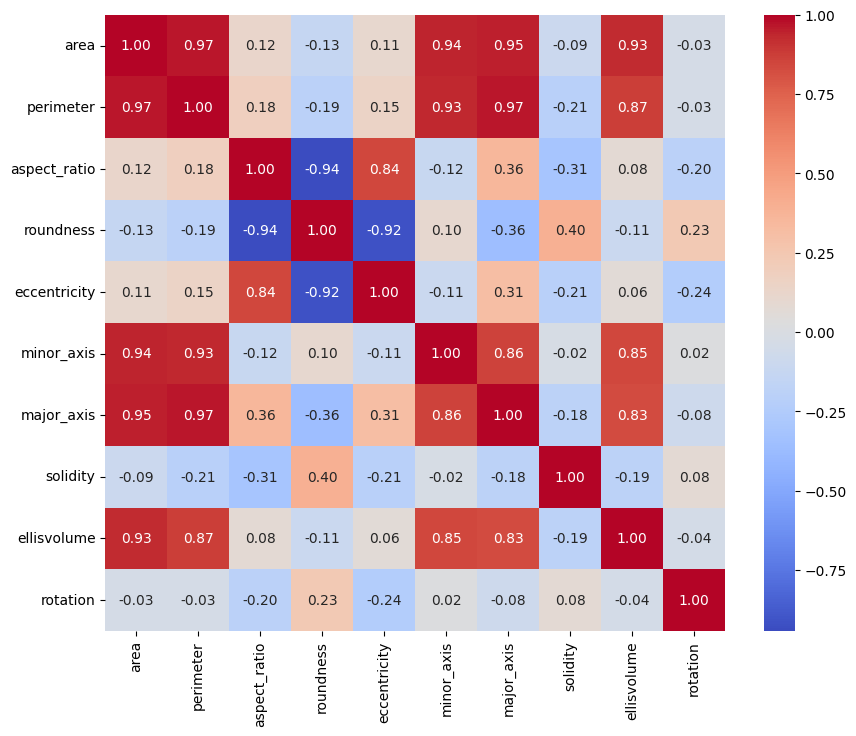

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Giả sử df là DataFrame chứa dữ liệu
corr_matrix = X.corr()

# Vẽ heatmap để xem các cặp feature có tương quan cao
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

# Đọc dữ liệu từ file Excel
file_path = "/content/cell_features.csv"
df = pd.read_csv(file_path)

X_copy = X.drop(['ellisvolume', 'perimeter', 'minor_axis', 'major_axis'], axis=1)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
# scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_copy)

# Chia tập train (80%) và test (20%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42, stratify=y)

# Huấn luyện các mô hình mạnh hơn

# Model 1: XGBoost
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# Model 2: LightGBM
lgbm_model = LGBMClassifier(n_estimators=100, learning_rate=0.01, random_state=42)
lgbm_model.fit(X_train, y_train)
lgbm_preds = lgbm_model.predict(X_test)

# Model 3: CatBoost (Không cần chuẩn hóa dữ liệu)
cat_model = CatBoostClassifier(iterations=100, learning_rate=0.01, depth=6, random_seed=42, verbose=0)
cat_model.fit(X_train, y_train)
cat_preds = cat_model.predict(X_test)

# Đánh giá mô hình
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))
print(classification_report(y_test, xgb_preds))

print("LightGBM Accuracy:", accuracy_score(y_test, lgbm_preds))
print(classification_report(y_test, lgbm_preds))

print("CatBoost Accuracy:", accuracy_score(y_test, cat_preds))
print(classification_report(y_test, cat_preds))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1397, number of negative: 684
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 2081, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.671312 -> initscore=0.714124
[LightGBM] [Info] Start training from score 0.714124
XGBoost Accuracy: 0.6995677233429395
              precision    recall  f1-score   support

           0       0.56      0.38      0.45       456
           1       0.74      0.86      0.79       932

    accuracy                           0.70      1388
   macro avg       0.65      0.62      0.62      1388
weighted avg       0.68      0.70      0.68      1388

LightGBM Accuracy: 0.7146974063400576
              precision    recall  f1-score   support

           0       0.65      0.29      0.40       456
  

Grid search after feature selection:

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Bộ tham số cần thử
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Grid Search để tìm tham số tốt nhất
xgb = XGBClassifier(random_state=42)
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Hiển thị kết quả tốt nhất
print("Best XGBoost Parameters:", grid_search.best_params_)
print("Best XGBoost Accuracy:", grid_search.best_score_)

# predict
grid_pred = grid_search.predict(X_test)
print(classification_report(y_test, grid_pred))

Best XGBoost Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best XGBoost Accuracy: 0.7294583563918096
              precision    recall  f1-score   support

           0       0.66      0.27      0.38       456
           1       0.72      0.93      0.81       932

    accuracy                           0.71      1388
   macro avg       0.69      0.60      0.60      1388
weighted avg       0.70      0.71      0.67      1388



In [ ]:
# SVM
from sklearn.svm import SVC
import itertools

regularization = [0.1, 1, 10, 100]
gamma = ['scale', 'auto', 0.1, 1, 10]

for c, g in itertools.product(regularization, gamma):
    model = SVC(kernel='rbf', C=c, gamma=g)
    model.fit(X_train, y_train)
    svm_pred = model.predict(X_test)
    print(f'Hyper-parameters: c={c}, gamma={g}')
    print(classification_report(y_test, svm_pred))
    print('\n')

Hyper-parameters: c=0.1, gamma=scale
              precision    recall  f1-score   support

           0       0.78      0.02      0.03       456
           1       0.67      1.00      0.80       932

    accuracy                           0.68      1388
   macro avg       0.73      0.51      0.42      1388
weighted avg       0.71      0.68      0.55      1388



Hyper-parameters: c=0.1, gamma=auto
              precision    recall  f1-score   support

           0       0.78      0.02      0.03       456
           1       0.67      1.00      0.80       932

    accuracy                           0.68      1388
   macro avg       0.73      0.51      0.42      1388
weighted avg       0.71      0.68      0.55      1388



Hyper-parameters: c=0.1, gamma=0.1
              precision    recall  f1-score   support

           0       0.78      0.04      0.08       456
           1       0.68      0.99      0.81       932

    accuracy                           0.68      1388
   macro avg    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Hyper-parameters: c=1, gamma=scale
              precision    recall  f1-score   support

           0       0.69      0.28      0.40       456
           1       0.73      0.94      0.82       932

    accuracy                           0.72      1388
   macro avg       0.71      0.61      0.61      1388
weighted avg       0.72      0.72      0.68      1388



Hyper-parameters: c=1, gamma=auto
              precision    recall  f1-score   support

           0       0.69      0.28      0.40       456
           1       0.73      0.94      0.82       932

    accuracy                           0.72      1388
   macro avg       0.71      0.61      0.61      1388
weighted avg       0.72      0.72      0.68      1388



Hyper-parameters: c=1, gamma=0.1
              precision    recall  f1-score   support

           0       0.71      0.24      0.35       456
           1       0.72      0.95      0.82       932

    accuracy                           0.72      1388
   macro avg       0.7

## Đặc trưng 2: Nhân có khía, chạy dọc/ngang, một phần hoặc toàn bộ nhân

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from scipy.fftpack import fft2, fftshift
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Định nghĩa thư mục chứa ảnh & file nhãn
image_folder = "/content/drive/MyDrive/Cell_Prediction/images/images"
labels_file = "/content/drive/MyDrive/Cell_Prediction/images/labels.json"

# Đọc nhãn từ file JSON
import json
with open(labels_file, 'r') as f:
    labels_dict = json.load(f)

# Hàm tính toán đặc trưng
def detect_edges(img):
    edges = cv2.Canny(img, 50, 150)
    return np.sum(edges) / (img.shape[0] * img.shape[1])

def detect_texture_fft(img):
    f_transform = np.log(np.abs(fftshift(fft2(img))) + 1)
    return np.mean(f_transform)

#  Tính đặc trưng cho tất cả ảnh
data = []
for filename in os.listdir(image_folder):
    if filename.endswith('.jpg'):
        image_path = os.path.join(image_folder, filename)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        # Tính toán đặc trưng
        edge_density = detect_edges(img)
        texture_value = detect_texture_fft(img)

        # Lấy nhãn từ labels.json
        filename_no_ext = os.path.splitext(filename)[0]
        label = labels_dict.get(filename_no_ext, None)
        if label is None:
            continue

        # Lưu vào danh sách
        data.append([filename, edge_density, texture_value] + [label[1]])  # Label_2

# Lưu vào file Excel
columns = ["Filename", "Edge Density", "FFT Texture", "Label_2"]
df = pd.DataFrame(data, columns=columns)
excel_path = "/content/drive/MyDrive/Cell_Prediction/nucleus_texture_features.xlsx"
df.to_excel(excel_path, index=False)

print(f"Đã lưu đặc trưng vào: {excel_path}")



✅ Đã lưu đặc trưng vào: /content/drive/MyDrive/Cell_Prediction/nucleus_texture_features.xlsx


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Đọc dữ liệu từ file Excel
file_path = "/content/drive/MyDrive/Cell_Prediction/nucleus_texture_features.xlsx"
df = pd.read_excel(file_path)

# Tiền xử lý dữ liệu
X = df[["Edge Density", "FFT Texture"]].values  # Đặc trưng
y = df["Label_2"].values  # Nhãn cần dự đoán

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Chia tập train (80%) và test (20%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42, stratify=y)

# Huấn luyện các mô hình mạnh hơn

# Model 1: XGBoost (thêm scale_pos_weight để cân bằng dữ liệu)
imbalance_ratio = np.bincount(y_train)[1] / np.bincount(y_train)[0]
xgb_model = XGBClassifier(n_estimators=200, learning_rate=0.05, scale_pos_weight=imbalance_ratio, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# Model 2: LightGBM (class_weight='balanced')
lgbm_model = LGBMClassifier(n_estimators=200, learning_rate=0.05, class_weight='balanced', random_state=42)
lgbm_model.fit(X_train, y_train)
lgbm_preds = lgbm_model.predict(X_test)

# Model 3: CatBoost (class_weights để cân bằng dữ liệu)
cat_model = CatBoostClassifier(iterations=200, learning_rate=0.05, depth=6, class_weights=[1, imbalance_ratio], random_seed=42, verbose=0)
cat_model.fit(X_train, y_train)
cat_preds = cat_model.predict(X_test)

# Đánh giá mô hình
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))
print(classification_report(y_test, xgb_preds))

print("LightGBM Accuracy:", accuracy_score(y_test, lgbm_preds))
print(classification_report(y_test, lgbm_preds))

print("CatBoost Accuracy:", accuracy_score(y_test, cat_preds))
print(classification_report(y_test, cat_preds))

# Lưu mô hình để sử dụng sau
joblib.dump(xgb_model, "/content/drive/MyDrive/Cell_Prediction/xgboost_label2.pkl")
joblib.dump(lgbm_model, "/content/drive/MyDrive/Cell_Prediction/lightgbm_label2.pkl")
joblib.dump(cat_model, "/content/drive/MyDrive/Cell_Prediction/catboost_label2.pkl")

print("Mô hình đã lưu thành công!")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1112, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 1894, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
🔹 XGBoost Accuracy: 0.5969912905779889
              precision    recall  f1-score   support

           0       0.53      0.23      0.32       521
           1       0.61      0.86      0.71       742

    accuracy                           0.60      1263
   macro avg       0.57      0.54      0.52      1263
weighted avg       0.58      0.60      0.55      1263

🔹 LightGBM Accuracy: 0.5423594615993665
              precision    recall  f1-score   support

           0       0.45      0.53      0.49       5

## Đặc trưng 3: có thể vùi tron nhân:

In [5]:
!pip install -q catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.4 MB/s eta 0:00:00


In [7]:
import os
import cv2
import numpy as np
import pandas as pd
from scipy.fftpack import fft2, fftshift
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib
import json

# Định nghĩa thư mục chứa ảnh & file nhãn
image_folder = "/content/image_with_points/"
labels_file = "/content/image_with_points/labels.json"

# Đọc nhãn từ file JSON
with open(labels_file, 'r') as f:
    labels_dict = json.load(f)

# Hàm tính toán đặc trưng

def detect_pseudoinclusion(img):
    """
    Phương pháp 1: Adaptive Thresholding - Phát hiện các vùng vùi trong nhân
    """
    adaptive_thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                            cv2.THRESH_BINARY_INV, 15, 5)
    contours, _ = cv2.findContours(adaptive_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return len(contours)  # Số vùng nhỏ bên trong nhân

def detect_watershed_regions(img):
    """
    Sử dụng Watershed Segmentation để phát hiện số vùng nhỏ trong nhân.
    """
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((3, 3), np.uint8)
    sure_bg = cv2.dilate(thresh, kernel, iterations=2)
    dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)

    # Chuyển sure_fg về uint8 để tránh lỗi subtract
    sure_fg = np.uint8(sure_fg)

    # Sửa lỗi khi trừ hai ma trận kiểu khác nhau
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Tạo marker để phân vùng Watershed
    _, markers = cv2.connectedComponents(sure_fg)
    markers += 1
    markers[unknown == 255] = 0

    # Áp dụng Watershed
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.watershed(img_color, markers)

    # Đếm số vùng trong nhân (sau Watershed)
    num_regions = len(np.unique(markers)) - 2  # Trừ background & nhân chính

    return num_regions


def detect_histogram_peaks(img):
    """
    Phương pháp 3: Histogram Peaks Analysis - Đếm số lượng đỉnh trong histogram
    """
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    hist = hist.flatten()
    return np.count_nonzero((hist[1:-1] > hist[:-2]) & (hist[1:-1] > hist[2:]))

# Tính đặc trưng cho tất cả ảnh
data = []
for filename in os.listdir(image_folder):
    if filename.endswith('.jpg'):
        image_path = os.path.join(image_folder, filename)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        # Tính toán đặc trưng
        pseudoinclusion_value = detect_pseudoinclusion(img)
        watershed_value = detect_watershed_regions(img)
        histogram_peaks = detect_histogram_peaks(img)

        # Lấy nhãn từ labels.json
        filename_no_ext = os.path.splitext(filename)[0]
        label = labels_dict.get(filename_no_ext, None)
        if label is None:
            continue
        else:
          label = label.get('label', None)

        # Lưu vào danh sách
        data.append([filename, pseudoinclusion_value, watershed_value, histogram_peaks] + [label[2]])  # Label_3

# Lưu vào file Excel
columns = ["Filename", "Pseudoinclusion Count", "Watershed Region Count", "Histogram Peaks Count", "Label_3"]
df = pd.DataFrame(data, columns=columns)
excel_path = "/content/nucleus_pseudoinclusion_features.xlsx"
df.to_excel(excel_path, index=False)

print(f"Đã lưu đặc trưng vào: {excel_path}")

# Đọc dữ liệu từ file Excel
df = pd.read_excel(excel_path)

# Tiền xử lý dữ liệu
X = df[["Pseudoinclusion Count", "Watershed Region Count", "Histogram Peaks Count"]].values
y = df["Label_3"].values  # Nhãn cần dự đoán

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Huấn luyện mô hình

# Model 1: XGBoost (thêm scale_pos_weight để cân bằng dữ liệu)
imbalance_ratio = np.bincount(y_train)[1] / np.bincount(y_train)[0]
xgb_model = XGBClassifier(n_estimators=200, learning_rate=0.05, scale_pos_weight=imbalance_ratio, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# Model 2: LightGBM (class_weight='balanced')
lgbm_model = LGBMClassifier(n_estimators=200, learning_rate=0.05, class_weight='balanced', random_state=42)
lgbm_model.fit(X_train, y_train)
lgbm_preds = lgbm_model.predict(X_test)

# Model 3: CatBoost (class_weights để cân bằng dữ liệu)
cat_model = CatBoostClassifier(iterations=200, learning_rate=0.05, depth=6, class_weights=[1, imbalance_ratio], random_seed=42, verbose=0)
cat_model.fit(X_train, y_train)
cat_preds = cat_model.predict(X_test)

# Đánh giá mô hình
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))
print(classification_report(y_test, xgb_preds))

print("LightGBM Accuracy:", accuracy_score(y_test, lgbm_preds))
print(classification_report(y_test, lgbm_preds))

print("CatBoost Accuracy:", accuracy_score(y_test, cat_preds))
print(classification_report(y_test, cat_preds))

# 📂 7️⃣ Lưu mô hình để sử dụng sau
joblib.dump(xgb_model, "/content/xgboost_label3.pkl")
joblib.dump(lgbm_model, "/content/lightgbm_label3.pkl")
joblib.dump(cat_model, "/content/catboost_label3.pkl")

print("Mô hình đã lưu thành công!")


Đã lưu đặc trưng vào: /content/nucleus_pseudoinclusion_features.xlsx


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1619, number of negative: 1156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 127
[LightGBM] [Info] Number of data points in the train set: 2775, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
XGBoost Accuracy: 0.5619596541786743
              precision    recall  f1-score   support

           0       0.32      0.04      0.08       289
           1       0.58      0.93      0.71       405

    accuracy                           0.56       694
   macro avg       0.45      0.49      0.40       694
weighted avg       0.47      0.56      0.45       694

LightGBM Accuracy: 0.4956772334293948
              precision    recall  f1-score  

#### Deep learning approach:

In [8]:
!git clone https://github.com/KerenLab/CellSighter.git

Cloning into 'CellSighter'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 74 (delta 18), reused 13 (delta 13), pack-reused 49 (from 1)
Receiving objects: 100% (74/74), 273.42 KiB | 2.65 MiB/s, done.
Resolving deltas: 100% (31/31), done.


Model:

In [9]:
from torchvision import models as models
import torch
from torch import nn


class Model(nn.Module):
    def __init__(self, input_len, num_classes):
        super(Model, self).__init__()
        self.model = models.resnet50(num_classes=num_classes)
        self.model.conv1 = torch.nn.Conv2d(input_len, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        ##Weights init
        nn.init.kaiming_normal_(self.model.conv1.weight, mode='fan_out', nonlinearity='relu')

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.model(x)
        if not self.training:
            x = self.softmax(x)
        return x

In [12]:
!git clone https://github.com/Kizza2014/thyroid_cell_prediction_on_he_images.git

Cloning into 'thyroid_cell_prediction_on_he_images'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (4/4), 4.79 KiB | 4.79 MiB/s, done.
